In [14]:
import pandas as pd
import numpy as np
data = pd.read_csv("./data_v_7_stc/meta/meta.txt", sep="\t", header=None)
np.unique(data.iloc[:,-1].values)

array(['background', 'bags', 'door', 'keyboard', 'knocking_door', 'ring',
       'speech', 'tool'], dtype=object)

In [43]:
#data[np.array(data.iloc[:,0], dtype="str") == 't_door_0068_time_stretch_5.wav']

data[data[0] == 't_door_0068_time_stretch_5.wav'][4]

5563    door
Name: 4, dtype: object

In [46]:
data[0]

0                        background_0001.wav
1         background_0001_time_stretch_0.wav
2         background_0001_time_stretch_1.wav
3        background_0001_time_stretch_10.wav
4        background_0001_time_stretch_11.wav
5        background_0001_time_stretch_12.wav
6        background_0001_time_stretch_13.wav
7         background_0001_time_stretch_2.wav
8         background_0001_time_stretch_3.wav
9         background_0001_time_stretch_4.wav
10        background_0001_time_stretch_5.wav
11        background_0001_time_stretch_6.wav
12        background_0001_time_stretch_7.wav
13        background_0001_time_stretch_8.wav
14        background_0001_time_stretch_9.wav
15                       background_0002.wav
16        background_0002_time_stretch_0.wav
17        background_0002_time_stretch_1.wav
18       background_0002_time_stretch_10.wav
19       background_0002_time_stretch_11.wav
20       background_0002_time_stretch_12.wav
21       background_0002_time_stretch_13.wav
22        

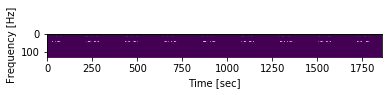

In [7]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

sample_rate, samples = wavfile.read('./data_v_7_stc/audio/ring_0115.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

plt.pcolormesh(times, frequencies, spectrogram)
plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [63]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks


""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac=0.5, window=np.hanning):
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))

    # zeros at beginning (thus center of 1st window should be for sample nr. 0)   
    samples = np.append(np.zeros(int(np.floor(frameSize/2.0))), sig)    
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))

    frames = stride_tricks.as_strided(samples, shape=(int(cols), frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win

    return np.fft.rfft(frames)    

""" scale frequency axis logarithmically """    
def logscale_spec(spec, sr=44100, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))

    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):        
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,int(scale[i]):], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,int(scale[i]):int(scale[i+1])], axis=1)

    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[int(scale[i]):])]
        else:
            freqs += [np.mean(allfreqs[int(scale[i]):int(scale[i+1])])]

    return newspec, freqs

""" plot spectrogram"""
def plotstft(audiopath, binsize=2**10, plotpath=None, colormap="jet"):
    samplerate, samples = wav.read(audiopath)

    s = stft(samples, binsize)

    sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)

    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel

    timebins, freqbins = np.shape(ims)

    print("timebins: ", timebins)
    print("freqbins: ", freqbins)

    plt.figure(figsize=(15, 7.5))
    plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")
    plt.colorbar()

    plt.xlabel("time (s)")
    plt.ylabel("frequency (hz)")
    plt.xlim([0, timebins-1])
    plt.ylim([0, freqbins])

    xlocs = np.float32(np.linspace(0, timebins-1, 5))
    plt.xticks(xlocs, ["%.02f" % l for l in ((xlocs*len(samples)/timebins)+(0.5*binsize))/samplerate])
    ylocs = np.int16(np.round(np.linspace(0, freqbins-1, 10)))
    plt.yticks(ylocs, ["%.02f" % freq[i] for i in ylocs])

    if plotpath:
        plt.savefig(plotpath, bbox_inches="tight", dpi=50)
    else:
        plt.show()

    plt.clf()
    #plt.savefig(ims)
    return ims

for i in range(4):
    filepath = './data_v_7_stc/audio/' + data[0][i]
    plotstft(filepath, plotpath='data[0][' + str(i) + ']')
    #plt.savefig(ims)

timebins:  296
freqbins:  513


/Users/Pablo/anaconda/envs/venv/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


timebins:  431
freqbins:  513
timebins:  426
freqbins:  513
timebins:  481
freqbins:  513
